# ML2: Dense Autoencoder for Song Orders:
Now that we've generated and stored the latent representation of each song (the "coordinates" of the movement through the 128D space), we can use this data to train another model (ML2). Later we want to use this model to generate new song orders, i.e. new sequences of coordinates. The model should be able to come up with a new "movement" through the 128D space. We've tried different architectures for this task (LSTM, Variational Autoencoder, Convolutional Autoencoder, LSTM-Autoencoder) and got best results with a Dense Autoencoder. One important reason, why we chose the Dense Autoencoder, is that it supports masking. Our songs have different durations, so the song orders have different lengths. We need to bring them to the same length by adding a place-holder value (0). Masking allows the model to ignore these padded values during training. 

In [1]:
from Dense_Autoencoder import Dense_Autoencoder
import numpy as np
import matplotlib.pyplot as plt
from Snippets import Snippets
from IPython.display import display, Audio
import librosa
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import math

## Input Data:
We load the array with all song orders. 

In [2]:
subfolder = "4.0_256"
model_name = "VAE_Vocals_128D_17388samples_20Epochs"
path = os.path.join("data_and_models", subfolder, model_name + "_song_order_all.npy")
song_orders = np.load(path, allow_pickle=True)

## Preprocessing Data
Before we can use the song orders for the Autoencoder, we need to adjust a few things. First, the Autoencoder works best with data that's normalized to values between 0 and 1. Second, all song orders need to have the same length. That is currently not the case, since the songs had a different duration. We can achieve it  by adding place-holder coordinates at the end of each song. Every coordinate has 128 values. Thus we will add 128 dimensional vectors filled with a place holder value until all songs have the same length. We choose 0 as the place-holder value. No "regular" data point should have the place-holder value, which means that we shouldn't normalise our data to be between 0 and 1, but between 0.01 and 1. Our placeholder value of 0 then corresponds in the denormalised data to a value slightly beneath the original minimum value.

If we want to reconstruct the original data structure, we need to find and delete all placeholder coordinates and denormalise the data. For the latter we need to store the original minimum and maximum values in our model. 

In [3]:
def pre_process_data(data):
    old_min, old_max = _find_min_max(data)
    normalized_data = Snippets._normalise(data, 0.01, 1, old_min, old_max)
    print("Normalized data.")
    padded_data = _pad_data(normalized_data)
    flattened_data = _flat_data(padded_data)
    return flattened_data, old_min, old_max

def _find_min_max(data):
    data_flat = np.asarray([item for order in data for item in order])
    min_val = data_flat.min()
    max_val = data_flat.max()
    return min_val, max_val

def _pad_data(data):
    max_length = _find_max_length(data)
    padded_data = _add_zero_vectors(data, max_length)
    return padded_data

def _find_max_length(data):
    max_song_length = 0

    for i in range(0, len(data)):
        if len(data[i]) > max_song_length:
            max_song_length = len(data[i])
    
    # We need the data to be a power of 2. So we find the next greater power of 2.
    max_song_length = 2 ** math.ceil(math.log2(max_song_length))
    
    print("The longest song has: " + str(max_song_length) + " snippets")
    
    return max_song_length

def _add_zero_vectors(data, max_length):
    padded_data = []
    for order in data:
        if order.shape[0] < max_length:
            padded_order = np.pad(order, ((0, max_length - order.shape[0]), (0, 0)), constant_values=(0, 0))
            padded_data.append(padded_order)
    padded_data = np.asarray(padded_data)
    print("Padded data - it now has the shape: " + str(padded_data.shape))
    return padded_data

def _flat_data(data):
    data_flat = data.reshape(data.shape[0], data.shape[1]*data.shape[2])
    print("Flattened data - it now has the shape: " + str(data_flat.shape))
    return data_flat

In [4]:
x_train, old_min, old_max = pre_process_data(song_orders)

Normalized data.
The longest song has: 512 snippets
Padded data - it now has the shape: (709, 512, 128)
Flattened data - it now has the shape: (709, 65536)


## Dense_Autoencoder class

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Masking, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pickle
from Snippets import Snippets
import math

"""
-------------------------------------------
DENSE AUTOENCODER CLASS
-------------------------------------------
"""


class Dense_Autoencoder:

    def __init__(self, input_shape, num_of_neurons, latent_space_dim, num_of_train_data=None, mask_value=0, old_min=0,
                 old_max=0):
        self.input_shape = input_shape  # dimension of input data: frequency-bins, time-windows, amplitude
        self.num_of_neurons = num_of_neurons
        self.latent_space_dim = latent_space_dim
        self._shape_before_bottleneck = None
        self.mask_value = mask_value

        self.encoder = None
        self.decoder = None
        self.model = None
        self.model_input = None
        self.num_of_train_data = num_of_train_data

        self.old_min = old_min
        self.old_max = old_max

        self.num_of_dense_layers = len(self.num_of_neurons)
        self._build()

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    """ 
    ------------
    Encoder Part 
    ------------
    """

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_shape, name="Encoder_Input")
        masking = Masking(mask_value=self.mask_value)(encoder_input)
        dense_layers = self._add_dense_layers(masking)
        bottleneck = self._add_bottleneck(dense_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="Encoder")

    def _add_dense_layers(self, encoder_input):
        x = encoder_input
        for i, num in enumerate(self.num_of_neurons):
            x = Dense(num, activation='relu', name=f"Dense_Layer_{i}")(x)
        return x

    def _add_bottleneck(self, x):
        x = Dense(self.latent_space_dim, name="Encoder_Output")(x)
        return x

    """
    ------------
    Decoder Part 
    ------------
    """

    def _build_decoder(self):
        decoder_input = Input(shape=self.latent_space_dim, name="Decoder_Input")
        dense_layers = self._add_transpose_dense_layers(decoder_input)
        decoder_output = self._add_decoder_output(dense_layers)
        self.decoder = Model(decoder_input, decoder_output, name="Decoder")

    def _add_transpose_dense_layers(self, x):
        for i in reversed(range(self.num_of_dense_layers)):  # go backwards trough layers.
            num = self.num_of_neurons[-i]
            x = Dense(num, activation='relu', name=f"Decoder_Dense_{i}")(x)
        return x

    def _add_decoder_output(self, x):
        output_layer = Dense(self.input_shape, activation='sigmoid')(x)
        return output_layer

    """
    ------------
    Autoencoder Part 
    ------------
    """

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="Autoencoder")

    def compile_model(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='mse')

    def train(self, x_train, x_test, batch_size, num_epochs):
        self.num_of_train_data = x_train.shape[0]
        hist = self.model.fit(x_train,
                              x_train,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              shuffle=True,
                              validation_data=(x_test, x_test))
        return hist

    def summary(self):
        self.model.summary()
        self.encoder.summary()
        self.decoder.summary()

    """
    ------------------
    Saving and Loading
    ------------------
    """

    def save(self, save_folder="."):
        self._create_folder(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)
        self._save_optimizer_state(save_folder)
        model_save_path = os.path.join(save_folder, "model.h5")
        self.model.save(model_save_path)

    def _create_folder(self, save_folder):
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.num_of_neurons,
            self.latent_space_dim,
            self.num_of_train_data,
            self.mask_value]

        save_path = os.path.join(save_folder, "parameters.pkl")

        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _save_optimizer_state(self, save_folder):
        # Save optimizer weights.
        symbolic_weights = getattr(self.model.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        optimizer_path = os.path.join(save_folder, "optimizer.pkl")
        with open(optimizer_path, 'wb') as f:
            pickle.dump(weight_values, f)

    @classmethod
    def load(cls, save_folder=".", learning_rate=0.0001):
        # Load the parameters:
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        loaded_autoencoder = Dense_Autoencoder(*parameters)

        # Compile the model (to be able to retrain it with additional data if needed)
        loaded_autoencoder.compile_model(learning_rate=learning_rate)

        # Load the Weights
        weights_path = os.path.join(save_folder, "weights.h5")
        loaded_autoencoder.model.load_weights(weights_path)

        # Load the Optimizer State
        loaded_autoencoder.model._make_train_function()

        optimizer_path = os.path.join(save_folder, "optimizer.pkl")
        with open(optimizer_path, 'rb') as f:
            weight_values = pickle.load(f)
        loaded_autoencoder.model.optimizer.set_weights(weight_values)

        return loaded_autoencoder


### Build the model
We can build a new model.

In [5]:
autoencoder = Dense_Autoencoder(input_shape=x_train.shape[1], 
                                num_of_neurons=(128,64), 
                                latent_space_dim=(32), 
                                mask_value=0,
                                old_min=old_min,
                                old_max=old_max)
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input (InputLayer)   [(None, 65536)]           0         
_________________________________________________________________
Encoder (Functional)         (None, 32)                8399072   
_________________________________________________________________
Decoder (Functional)         (None, 65536)             8464576   
Total params: 16,863,648
Trainable params: 16,863,648
Non-trainable params: 0
_________________________________________________________________
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input (InputLayer)   [(None, 65536)]           0         
_________________________________________________________________
masking (Masking)            (None, 65536)             0         
__________________________

2022-04-18 16:51:36.589196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
LEARNING_RATE =  0.0001
EPOCHS = 20
BATCH_SIZE = 4

x_train, x_test, _, _ = train_test_split(x_train, x_train, shuffle=True, test_size=0.1)

autoencoder.compile_model(LEARNING_RATE)
history = autoencoder.train(x_train, x_test, num_epochs=EPOCHS, batch_size=BATCH_SIZE)

2022-04-18 16:51:37.421527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
160/160 [==============================] - 11s 66ms/step - loss: 0.0466 - val_loss: 0.0106
Epoch 2/20
160/160 [==============================] - 10s 62ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 3/20
160/160 [==============================] - 10s 60ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
160/160 [==============================] - 9s 59ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 5/20
160/160 [==============================] - 9s 59ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/20
160/160 [==============================] - 9s 59ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 7/20
160/160 [==============================] - 9s 59ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 8/20
160/160 [==============================] - 9s 58ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/20
160/160 [==============================] - 10s 60ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/20
160/160 [==============================] - 9s 58ms/step - loss: 0.0017 - va

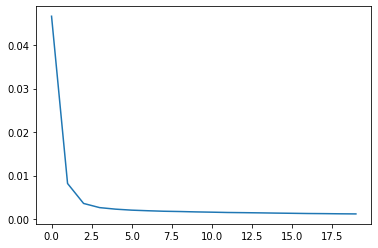

In [7]:
plt.plot(history.history['loss'])

# Check Results
We can now check how good the autoencoder is in reconstructing a song order. We feed the encoder a song order to get it's latent representation. We can then feed the decoder this latent representation to get a reconstruction of the song order.

In [8]:
song_num = np.random.randint(0, len(song_orders)-1)
test_sample = x_train[song_num]
test_sample = test_sample.reshape(1, test_sample.shape[0])

latent_representation = autoencoder.encoder.predict(test_sample)
reconstructed_data = autoencoder.decoder.predict(latent_representation)

Before we can look at the reconstruction, we need to undo the normalization and the padding. For the latter we look for values that are very close to our place-holder value, which was slightly beneath the original minimum. As soon as we detect a 128D coordinate that is filled with 128 values, which are very close to our place-holder we'll delete all following coordinates. To check if that works we can just compare the length of the original song order with the length of the reconstructed song order.

In [18]:
reshaped_reconstructed_data = reconstructed_data.reshape(int(reconstructed_data.shape[1]/128),128)
denorm_reconstructed_data = Snippets._denormalise(reshaped_reconstructed_data, 0.001, 1, autoencoder.old_min, autoencoder.old_max)
pad_prediction = np.argwhere(denorm_reconstructed_data< (old_min + (abs(old_min - old_max) * 0.25)))[:,0].min() # predict which coordinates were probably just filled up
cut_reconstructed_data = denorm_reconstructed_data[:pad_prediction]
print("Our reconstructed song has " + str(cut_reconstructed_data.shape) + " coordinates")

original = song_orders[song_num]
print("The original song has " + str(original.shape) + " coordinates")



Our reconstructed song has (47, 128) coordinates
The original song has (45, 128) coordinates


This is the original


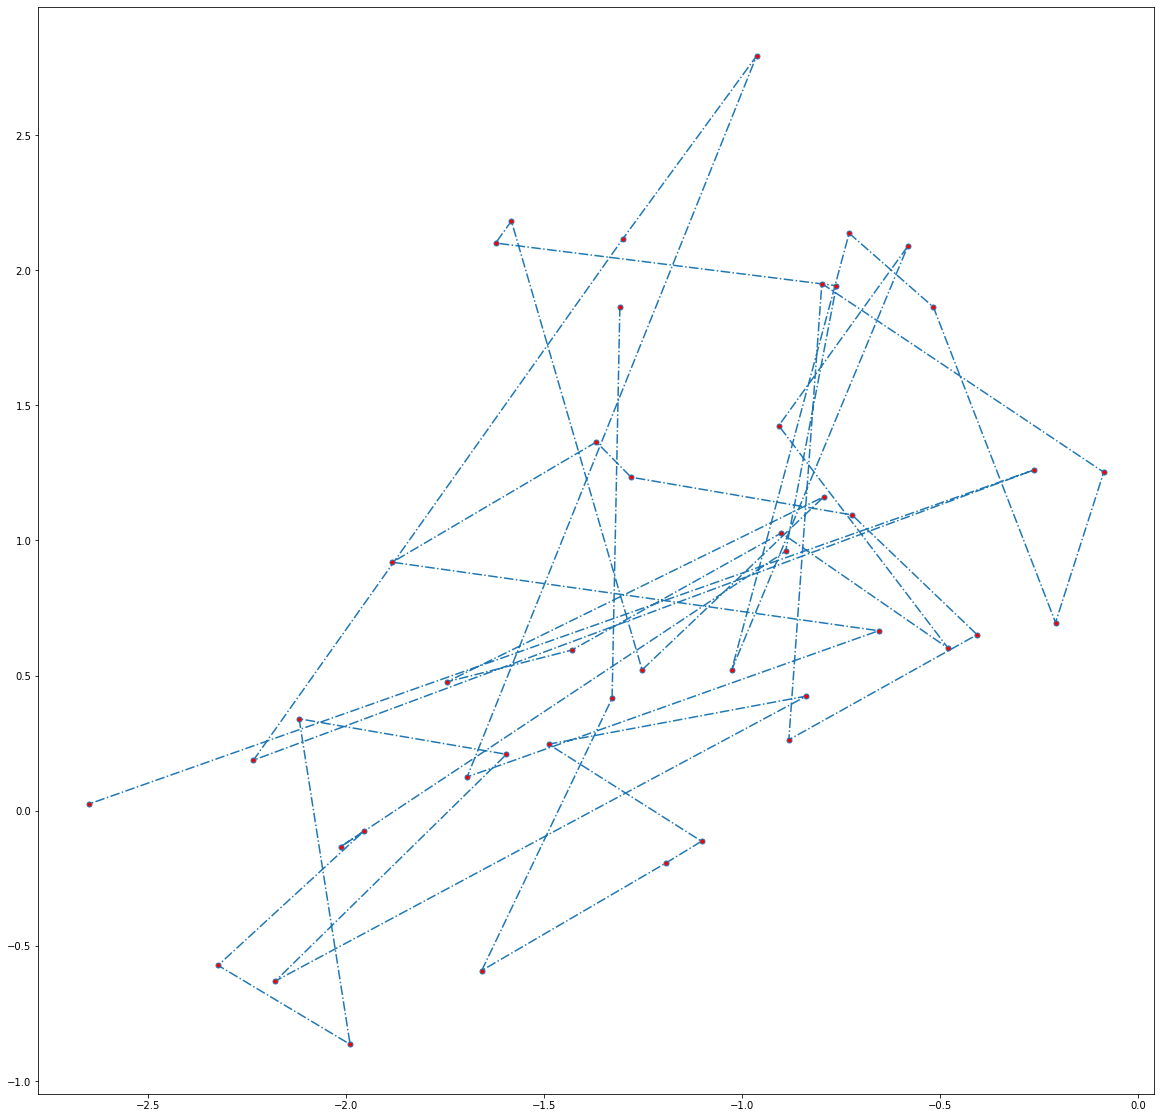

In [19]:
print("This is the original")
plt.figure(figsize=(20,20))
plt.plot(original[:, 0], original[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

This is the reconstruction


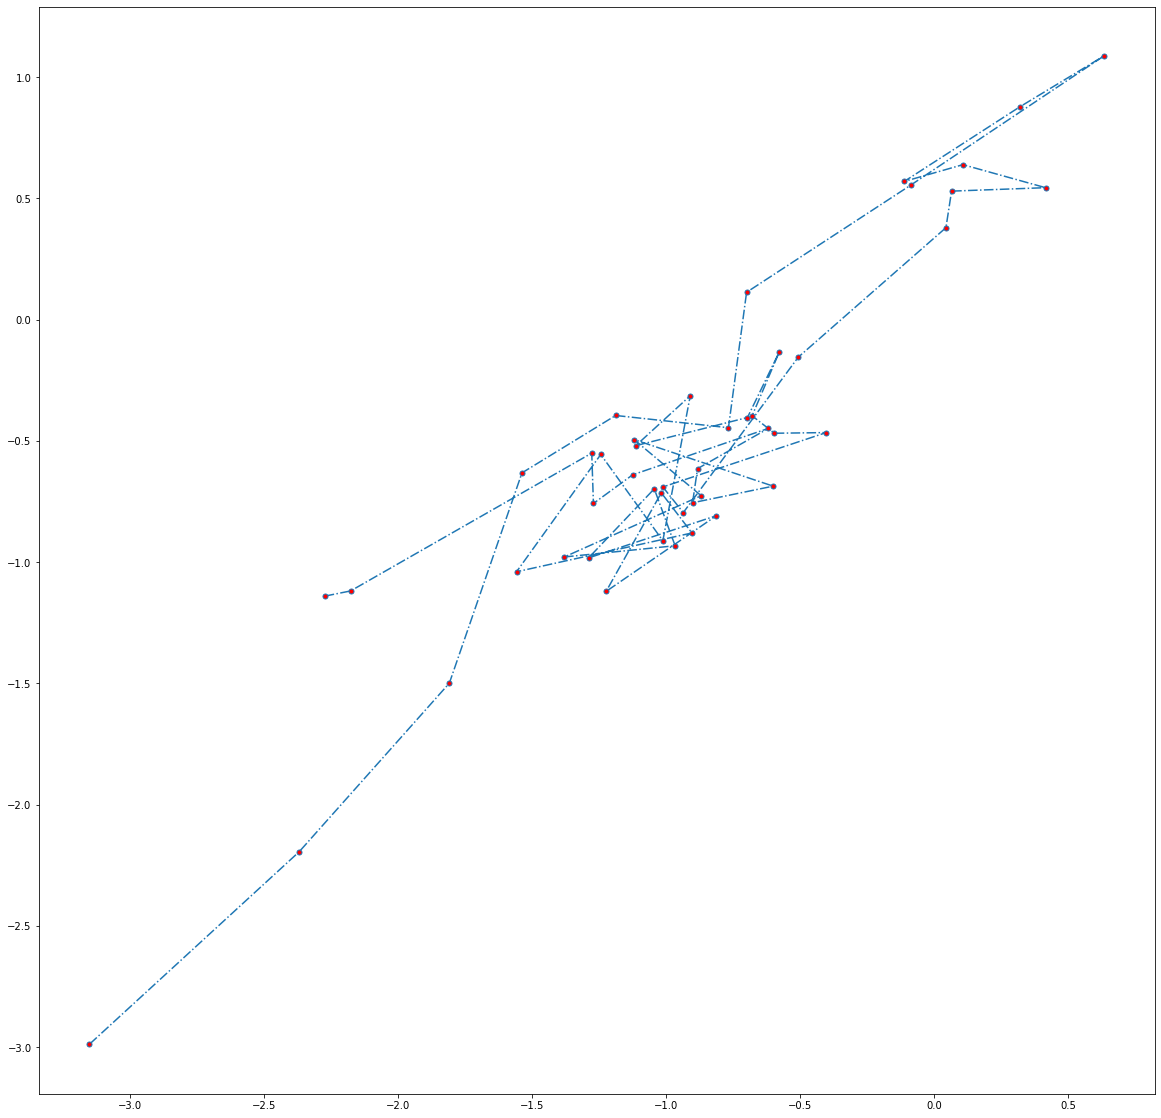

In [20]:
print("This is the reconstruction")
plt.figure(figsize=(20,20))
plt.plot(cut_reconstructed_data[:, 0], cut_reconstructed_data[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

In [12]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2


path = os.path.join("data_and_models", subfolder, "VAE_Vocals_128D_17388samples_20Epochs")
snippet_autoencoder = VAE.load(path)

reconstructed_data = cut_reconstructed_data.reshape(cut_reconstructed_data.shape[0], cut_reconstructed_data.shape[1])
      
reconstructed_signal, reconstructed_spectos = Snippets.latent_representation_to_pcm(latent_representations=reconstructed_data,
                                                                                    model=snippet_autoencoder, 
                                                                                    hop_length=HOP_LENGTH, 
                                                                                    n_fft=N_FFT, 
                                                                                    win_length=WIN_LENGTH)

NameError: name 'VAE' is not defined

In [ ]:
display(Audio(reconstructed_signal, rate=44100))

In [ ]:
folder_path = os.path.join('demo_data', 'stems2')
paths = librosa.util.find_files(folder_path, ext=['wav'])
original_song, _ = librosa.load(paths[song_num],sr=44100, mono=True)

print("This is the original song: \n")
display(Audio(original_song, rate=44100))


## Improving the results
As you can see in the plot and hear in the audio quiet a lot of information gets lost in ML2. The reason for that is probably that we have trained it on just a few samlpes. Because of time and resource restrictions we only used 300-800 songs for our different models. We assume that the results could be improved by using significantly more data.